In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
TICTACTOE GAME CLASS

this class inspired heavily by https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
'''

class tictactoe:
    # players are identified as 1 and -1.
    # board is just a 3x3 grid of zeros at first.
    # when a player moves, update that spot from
    # a zero to a 1 or -1.
    def __init__(self, player1, player2, numrows=3, numcols=3, wincount=3, gravitymove=False, randinit=False):
        self.numrows = numrows
        self.numcols = numcols
        self.wincount = wincount
        self.board = np.zeros((self.numrows, self.numcols))
        self.player1 = player1
        self.player2 = player2
        self.gravitymove=gravitymove
        self.randinit=randinit
        self.isEnd = False
        self.boardID = None
        # init p1 plays first
        self.playerSymbol = 1
        
    # unique identifier for current board state
    def getBoardID(self):
        self.boardID = str(self.board.reshape(self.numrows*self.numcols))
        return self.boardID
    
    def availablePositions(self):
        positions = []
        for i in range(0, self.numrows):
            for j in range(0, self.numcols):
                if self.board[i, j] == 0:
                    if self.gravitymove:
                        #print(i, j)
                        if i+1 == self.numrows:
                            positions.append((i, j))
                        elif (i+1 < self.numrows and self.board[i+1, j] != 0):
                            #print("use")
                            #print(i, j)
                            positions.append((i, j))
                    else:
                        positions.append((i, j))
        #print(positions)
        return positions
    
    def updateMove(self, position):
        self.board[position] = self.playerSymbol
        # switch to player -1 or 1
        self.playerSymbol = -1*self.playerSymbol
        
    def checkWinner(self):
        #print("checking winner")
        for i in range(0, self.numrows):
            #print('row')
            for j in range(0, self.numcols-self.wincount+1):
                #print("col")
                if sum(self.board[i,j:j+self.wincount]) == self.wincount:
                    self.isEnd=True
                    return 1
                if sum(self.board[i,j:j+self.wincount]) == -1*self.wincount:
                    self.isEnd=True
                    return -1
        # cols
        for i in range(0, self.numcols):
            for j in range(0, self.numrows-self.wincount+1):
                if sum(self.board[j:j+self.wincount,i]) == self.wincount:
                    #print("win")
                    self.isEnd=True
                    return 1
                if sum(self.board[j:j+self.wincount,i]) == -1*self.wincount:
                    self.isEnd=True
                    return -1
            '''
            if sum(self.board[:,i]) == self.wincount:
                self.isEnd=True
                return 1
            if sum(self.board[:,i]) == -1*self.wincount:
                self.isEnd=True
                return -1
            '''
        # diags
        # top left to bot right
        for i in range(0, self.numrows-self.wincount+1):
            for j in range(0, self.numcols-self.wincount+1):
                diag1 = sum([self.board[i+k,j+k] for k in range(0, self.wincount)])
                if abs(diag1) == self.wincount:
                    self.isEnd = True
                    return int(diag1//self.wincount)
        # top right to bottom left
        for i in range(0, self.numrows-self.wincount+1):
            for j in range(self.wincount-1, self.numcols):
                diag2 = sum([self.board[i+k,j-k] for k in range(0, self.wincount)])
                if abs(diag2) == self.wincount:
                    self.isEnd = True
                    return int(diag2//self.wincount)
        '''
        diag1 = sum([self.board[i,i] for i in range(0, self.wincount)])
        diag2 = sum([self.board[i,self.numcols-i-1] for i in range(0, self.wincount)])
        diag = max(abs(diag1), abs(diag2))
        if diag == self.wincount:
            self.isEnd = True
            if diag1 == self.wincount or diag2 == self.wincount:
                return 1
            else:
                return -1
        '''
        # tie
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        return None
    
    def giveReward(self):
        winner = self.checkWinner()
        if winner == 1:
            self.player1.feedReward(1)
            self.player2.feedReward(-0.1)
        if winner == -1:
            self.player1.feedReward(0)
            self.player2.feedReward(1)
        else:
            # keep in mind that a tie is worse for player 1 who has more moves to win with
            self.player1.feedReward(0.1)
            self.player2.feedReward(0.9)
            
    def reset(self):
        self.board = np.zeros((self.numrows, self.numcols))
        self.boardID = None
        self.isEnd = False
        self.playerSymbol = 1
        
    '''
    PLAYING
    '''
    
    '''
    play against self
    '''
    def play(self, trainingrounds=100):
        wins = []
        meanrand = (self.player1.explore_rate**2)*self.numrows*self.numcols
        for i in tqdm(range(0, trainingrounds)):
            rand=False
            randmoves1 = 0
            randmoves2 = 0
            if self.randinit:
                randmoves1 = int(round(np.random.normal(meanrand, meanrand/2)))
                randmoves2 = int(round(np.random.normal(meanrand, meanrand/2)))
            while not self.isEnd:
                positions = self.availablePositions()
                if randmoves1 > 0:
                    rand=True
                    randmoves1 = randmoves1-1
                player1move = self.player1.chooseAction(positions, self.board, self.playerSymbol, rand=rand)
                rand=False
                self.updateMove(player1move)
                boardID = self.getBoardID()
                self.player1.addState(boardID)
                
                win = self.checkWinner()
                # if player 1 wins
                if win != None:
                    self.giveReward()
                    self.player1.reset()
                    self.player2.reset()
                    self.reset()
                    break
                # if player 1 did not win
                else:
                    positions = self.availablePositions()
                    if randmoves2 > 0:
                        rand=True
                        randmoves2 -= 1
                    player2move = self.player2.chooseAction(positions, self.board, self.playerSymbol, rand=rand)
                    rand=False
                    self.updateMove(player2move)
                    boardID = self.getBoardID()
                    self.player2.addState(boardID)

                    win = self.checkWinner()
                    # if player 1 wins
                    if win != None:
                        self.giveReward()
                        self.player1.reset()
                        self.player2.reset()
                        self.reset()
                        break
            wins.append(win)
        return wins
    '''
    Play against human player
    '''
    def playhuman(self, prints=True):
        self.showBoard()
        while not self.isEnd:
            positions = self.availablePositions()
            player1move = self.player1.chooseAction(positions, self.board, self.playerSymbol)
            self.updateMove(player1move)
            self.showBoard()
            win = self.checkWinner()
            if win != None:
                self.reset()
                break
            else:
                positions = self.availablePositions()
                player2move = self.player2.chooseAction(positions, self.board, self.playerSymbol)
                self.updateMove(player2move)
                self.showBoard()
                win = self.checkWinner()
                if win != None:
                    self.reset()
                    break
        if prints:
            if win == 1:
                print(self.player1.name, "wins!")
            elif win == -1:
                print(self.player2.name, "wins!")
            else:
                print("tie!")
        return win
                    
    def showBoard(self):
        # player1: x  player2: o
        colcounts = "   "
        for j in range(0, self.numcols):
            colcounts += f"| {j} "
        colcounts += "|"
        print(colcounts)
        for i in range(0, self.numrows):
            divider = '-----'
            for j in range(0, self.numcols):
                divider += '----'
            print(divider)
            out = f'{i}  | '
            for j in range(0, self.numcols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print(divider+'\n')

In [3]:
''' 
PLAYER CLASS

Also heavily inspired by https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542

'''
class player:
    def __init__(self, name, explore_rate=0.3, learning_rate = 0.2):
        self.name = name
        self.states = []
        self.learningrate = learning_rate
        self.explore_rate = explore_rate
        self.decay_gamma = 0.9
        self.states_values = {}
        
    def getBoardID(self, board):
        boardID = str(board.reshape(len(board)*len(board[0])))
        return boardID
        
    def chooseAction(self, positions, current_board, symbol, rand=False):
        # choose whether to explore or not
        action = positions[np.random.choice(len(positions))]
        if not rand:
            if np.random.uniform(0, 1) >= self.explore_rate:
                value_max = -10000
                for position in positions:
                    nextBoard = current_board.copy()
                    nextBoard[position] = symbol
                    nextBoardHash = self.getBoardID(nextBoard)
                    value = 0
                    if self.states_values.get(nextBoardHash) != None:
                        value = self.states_values.get(nextBoardHash)
                    if value >= value_max:
                        value_max = value
                        action = position
        return action
    
    def addState(self, state):
        self.states.append(state)
    
    def feedReward(self, reward):
        for state in reversed(self.states):
            if self.states_values.get(state) == None:
                self.states_values[state] = 0
            self.states_values[state] += self.learningrate * (self.decay_gamma * reward - self.states_values[state])
            reward = self.states_values[state]
            
    def reset(self):
        self.states = []
        
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_values, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_values = pickle.load(fr)
        fr.close()


In [4]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions, board, playerSymbol):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass


In [ ]:
numrounds = 400000
p102 = player("p102", 0.3)
p202 = player("p202", 0.3)

st = tictactoe(p102, p202)
print("training...")
wins02 = st.play(numrounds)

p102.savePolicy()
p202.savePolicy()

In [ ]:
numrounds = 400000
p103 = player("p103", 0.3)
p203 = player("p203", 0.3)

st = tictactoe(p103, p203)
print("training...")
wins03 = st.play(numrounds)

p103.savePolicy()
p203.savePolicy()

In [ ]:
p101 = player("p101", 0.1)
p201 = player("p201", 0.1)

st = tictactoe(p101, p201)
print("training...")
wins01 = st.play(numrounds)

p101.savePolicy()
p201.savePolicy()

In [ ]:
# plot different exploration rates

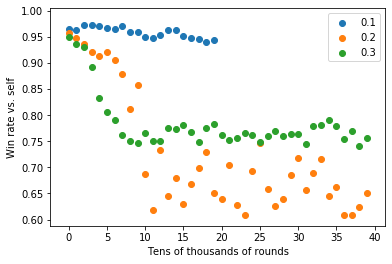

In [26]:
'''
varying explore rates and how they learn
'''
numrounds = 400000
x = []
y1 = []
y2 = []
y3 = []
for i in range(0, numrounds//10000):
    x.append(i)
    y1.append(np.mean(np.abs(wins01[(i*10000):(i+1)*10000])))
    y2.append(np.mean(np.abs(wins02[(i*10000):(i+1)*10000])))
    y3.append(np.mean(np.abs(wins03[(i*10000):(i+1)*10000])))
    
plt.scatter(x, y1, label="0.1")
plt.scatter(x, y2, label="0.2")
plt.scatter(x, y3, label="0.3")
plt.legend()
plt.xlabel("Tens of thousands of rounds")
plt.ylabel("Win rate vs. self")
plt.show()

In [ ]:
'''
slowly adjusting down LR
NOTE: code for graph got cut accidentally
'''
p1newlearn = player("LRadj1", explore_rate=0.1)
p2newlearn = player("LRadj2", explore_rate=0.1)
p1newlearn.loadPolicy("policy_p1")
p2newlearn.loadPolicy("policy_p2")

st = tictactoe(p1newlearn, p2newlearn)
print("training...")
winsnew = st.play(10000)

p1newlearn.savePolicy()
p2newlearn.savePolicy()

p1newlearn = player("LRadj1", explore_rate=0.05)
p2newlearn = player("LRadj2", explore_rate=0.05)
p1newlearn.loadPolicy("policy_LRadj1")
p2newlearn.loadPolicy("policy_LRadj2")

st = tictactoe(p1newlearn, p2newlearn)
print("training...")
winsnew = st.play(10000)

p1newlearn.savePolicy()
p2newlearn.savePolicy()

In [5]:
'''
DYNAMIC EXPLORE RATE
'''
def makedynamic(numrounds=15000, numexplores=11, expstart=0.4, movingalpha=False,
                p1dynamic=None, p2dynamic=None, 
                rows=3, cols=3, winc=3, gmove=False, 
                randinit=False, stratnames='dynamic'):
    # moving alpha - have alpha (learning rate) be equal to explore rate -- so learn faster
    # in exploration stage, learn slower in convergence stage
    x= []
    ydynamic = []
    expdiff = 0
    if numexplores > 1:
        expdiff = expstart/(numexplores-1)
    print(expdiff)
    winsdynamic = []
    if not movingalpha:
        alpha=0.2
    else:
        alpha=expstart
    if p1dynamic == None:
        p1dynamic = player(stratnames+"1", explore_rate=expstart, learning_rate=alpha)
    if p2dynamic == None:
        p2dynamic = player(stratnames+"2", explore_rate=expstart, learning_rate=alpha)

    for i in range(0, numexplores):
        exprate = round(expstart-expdiff*i, 2)
        # reset learning rate for next stage
        if movingalpha:
            alpha=exprate
            if alpha==0:
                alpha = 0.01
        
        st = tictactoe(p1dynamic, p2dynamic, numrows=rows, numcols=cols, wincount=winc, gravitymove=gmove, randinit=randinit)
        print(f"training for explore rate {exprate} and alpha {alpha}")
        winsdynamic.extend(st.play(numrounds))

        p1dynamic.savePolicy()
        p2dynamic.savePolicy()
        
        
        
        p1dynamic = player(stratnames+"1", explore_rate=exprate, learning_rate=alpha)
        p2dynamic = player(stratnames+"2", explore_rate=exprate, learning_rate=alpha)
        p1dynamic.loadPolicy("policy_"+stratnames+"1")
        p2dynamic.loadPolicy("policy_"+stratnames+"2")

    for i in range(0, numrounds*numexplores//100):
        x.append(i)
        ydynamic.append(np.mean(np.abs(winsdynamic[(i*100):(i+1)*100])))

    plt.scatter(x, ydynamic, s=4)
    plt.ylim(0, 1)
    plt.xlabel("Training round / 100")
    plt.ylabel("Rate of games with clear winner")
    plt.title(f"Rate of wins vs. training rounds with {numexplores} explore rates from {0.4} down to 0")
    for i in range(0, numexplores):
        plt.vlines(i*numrounds//100, 0, 1)
    plt.show()
    
    return p1dynamic, p2dynamic

0.04
training for explore rate 0.4


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:03<00:00, 235.02it/s]


training for explore rate 0.36


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:14<00:00, 202.35it/s]


training for explore rate 0.32


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:17<00:00, 193.14it/s]


training for explore rate 0.28


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:24<00:00, 177.07it/s]


training for explore rate 0.24


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:24<00:00, 177.23it/s]


training for explore rate 0.2


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:30<00:00, 165.32it/s]


training for explore rate 0.16


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:43<00:00, 144.50it/s]


training for explore rate 0.12


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:42<00:00, 147.04it/s]


training for explore rate 0.08


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:52<00:00, 132.89it/s]


training for explore rate 0.04


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:53<00:00, 132.20it/s]


training for explore rate 0.0


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:54<00:00, 131.23it/s]


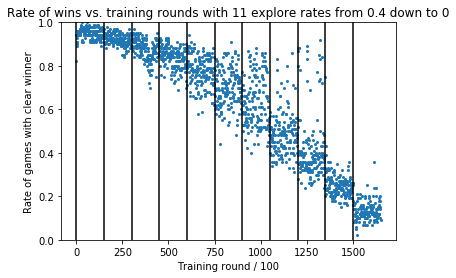

In [20]:
makedynamic(15000, 11, 0.4)

0.04
training for explore rate 0.4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 272.10it/s]


training for explore rate 0.36


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 243.37it/s]


training for explore rate 0.32


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.53it/s]


training for explore rate 0.28


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:50<00:00, 196.70it/s]


training for explore rate 0.24


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.17it/s]


training for explore rate 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 159.21it/s]


training for explore rate 0.16


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.81it/s]


training for explore rate 0.12


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 131.64it/s]


training for explore rate 0.08


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 144.14it/s]


training for explore rate 0.04


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 134.28it/s]


training for explore rate 0.0


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 120.58it/s]


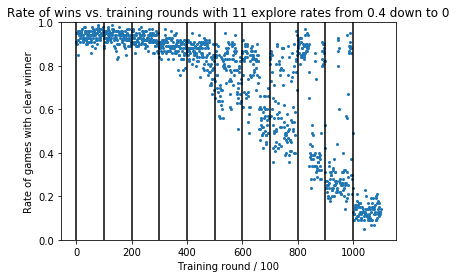

In [19]:
makedynamic(10000, 11, 0.4)

0.05
training for explore rate 0.4 and alpha 0.2


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:41<00:00, 61.99it/s]


training for explore rate 0.35 and alpha 0.2


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:55<00:00, 86.27it/s]


training for explore rate 0.3 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 238.49it/s]


training for explore rate 0.25 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:51<00:00, 193.22it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:53<00:00, 187.11it/s]


training for explore rate 0.15 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:57<00:00, 175.44it/s]


training for explore rate 0.1 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:06<00:00, 149.85it/s]


training for explore rate 0.05 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:31<00:00, 109.29it/s]


training for explore rate 0.0 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:23<00:00, 119.65it/s]


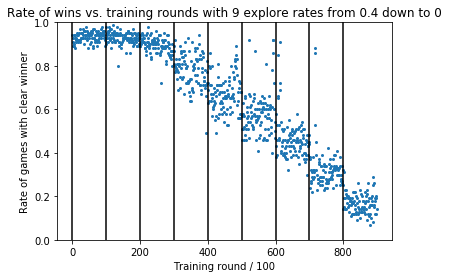

In [11]:
p1, p2 = makedynamic(10000, 9, 0.4)

In [13]:
# p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(p1, human)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   |   |   | 
-----------------

Input your action row:0
Input your action col:0
   | 0 | 1 | 2 |
-----------------
0  | o |   |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   |   |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  | o | x |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   |   |   | 
-----------------

Input your action row:2
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  | o | x |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   | o |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  | o | x |   | 
-----------------
1  | x | x |   | 
-----------------
2  |   | o |   | 
-----------------

Input your action row:1
Input your actio

0

Dynamic step size (alpha)?

0.05
training for explore rate 0.4 and alpha 0.4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.52it/s]


training for explore rate 0.35 and alpha 0.35


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:06<00:00, 149.45it/s]


training for explore rate 0.3 and alpha 0.3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 158.75it/s]


training for explore rate 0.25 and alpha 0.25


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:57<00:00, 172.75it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:57<00:00, 172.59it/s]


training for explore rate 0.15 and alpha 0.15


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:07<00:00, 148.66it/s]


training for explore rate 0.1 and alpha 0.1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 107.92it/s]


training for explore rate 0.05 and alpha 0.05


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 120.99it/s]


training for explore rate 0.0 and alpha 0.01


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:20<00:00, 123.61it/s]


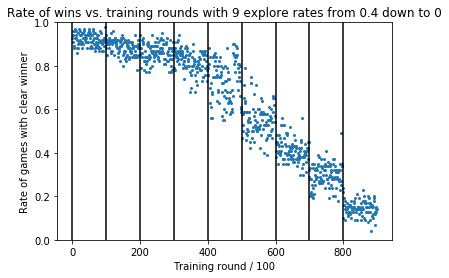

In [17]:
p1, p2 = makedynamic(10000, 9, 0.4, movingalpha = True)

0.05
training for explore rate 0.4 and alpha 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:35<00:00, 227.21it/s]


training for explore rate 0.35 and alpha 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:40<00:00, 199.88it/s]


training for explore rate 0.3 and alpha 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:54<00:00, 147.92it/s]


training for explore rate 0.25 and alpha 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:59<00:00, 134.00it/s]


training for explore rate 0.2 and alpha 0.2


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.67it/s]


training for explore rate 0.15 and alpha 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:01<00:00, 129.53it/s]


training for explore rate 0.1 and alpha 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:05<00:00, 121.71it/s]


training for explore rate 0.05 and alpha 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:03<00:00, 125.59it/s]


training for explore rate 0.0 and alpha 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:58<00:00, 136.96it/s]


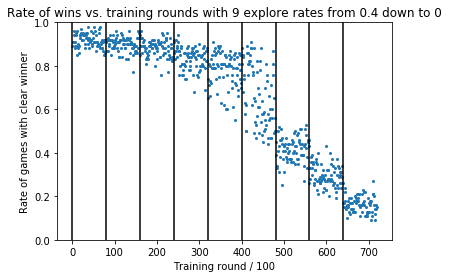

In [18]:
p1, p2 = makedynamic(8000, 9, 0.4, movingalpha = True)

0.05
training for explore rate 0.4 and alpha 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:23<00:00, 258.55it/s]


training for explore rate 0.35 and alpha 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:28<00:00, 209.09it/s]


training for explore rate 0.3 and alpha 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:31<00:00, 192.41it/s]


training for explore rate 0.25 and alpha 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:36<00:00, 165.15it/s]


training for explore rate 0.2 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:48<00:00, 122.76it/s]


training for explore rate 0.15 and alpha 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:55<00:00, 107.48it/s]


training for explore rate 0.1 and alpha 0.1


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:03<00:00, 94.48it/s]


training for explore rate 0.05 and alpha 0.05


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:01<00:00, 97.55it/s]


training for explore rate 0.0 and alpha 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:59<00:00, 100.44it/s]


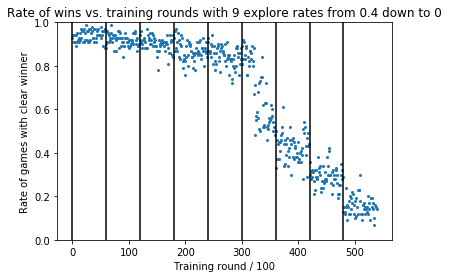

In [19]:
p1, p2 = makedynamic(6000, 9, 0.4, movingalpha = True)

0.05
training for explore rate 0.4 and alpha 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 251.30it/s]


training for explore rate 0.35 and alpha 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 236.06it/s]


training for explore rate 0.3 and alpha 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 214.20it/s]


training for explore rate 0.25 and alpha 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 204.31it/s]


training for explore rate 0.2 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 161.97it/s]


training for explore rate 0.15 and alpha 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 133.19it/s]


training for explore rate 0.1 and alpha 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 101.48it/s]


training for explore rate 0.05 and alpha 0.05


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 85.87it/s]


training for explore rate 0.0 and alpha 0.01


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:18<00:00, 64.08it/s]


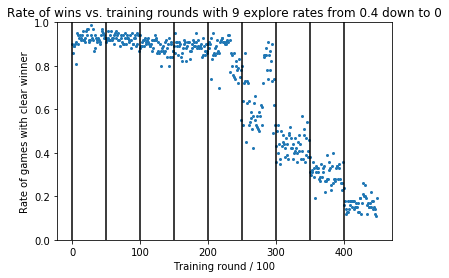

In [21]:
p1, p2 = makedynamic(5000, 9, 0.4, movingalpha = True)

In [24]:
# p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(human, p2)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

Input your action row:1
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   |   |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   |   | o | 
-----------------

Input your action row:0
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   |   | o | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   | o | o | 
-----------------

Input your action row:2
Input your action col:0
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | x |   | 
-----------------
2  | x | o | o | 
-----------

0

In [11]:
'''
First test of gravity restriction
'''
# p1 = player("computer", explore_rate=0)
human2 = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(p1, human2, gravitymove=True)
game.playhuman()

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
Input your action row:1
Input your action col:1
-------------
|   |   |   | 
-------------
|   | o |   | 
-------------
|   | x |   | 
-------------
-------------
|   |   |   | 
-------------
|   | o |   | 
-------------
| x | x |   | 
-------------
Input your action row:2
Input your action col:2
-------------
|   |   |   | 
-------------
|   | o |   | 
-------------
| x | x | o | 
-------------
-------------
|   |   |   | 
-------------
| x | o |   | 
-------------
| x | x | o | 
-------------
Input your action row:0
Input your action col:0
-------------
| o |   |   | 
-------------
| x | o |   | 
-------------
| x | x | o | 
-------------
human wins!


-1

In [ ]:
'''
Testing dynamic explore rate with gravity restricted training
'''

0.05
training for explore rate 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 386.69it/s]


training for explore rate 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 364.23it/s]


training for explore rate 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 324.29it/s]


training for explore rate 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 294.93it/s]


training for explore rate 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 258.56it/s]


training for explore rate 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 224.22it/s]


training for explore rate 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 181.48it/s]


training for explore rate 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 206.07it/s]


training for explore rate 0.0


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 200.31it/s]


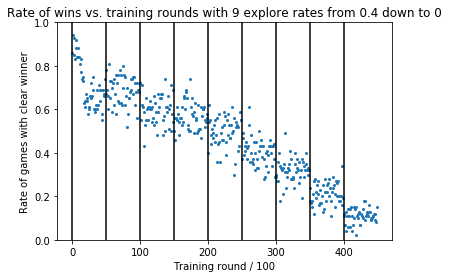

In [12]:
p1grav, p2grav = makedynamic(5000, 9, 0.4, gmove=True)

In [15]:
# p1 = player("computer", explore_rate=0)
human2 = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(p1, human2, gravitymove=True)
game.playhuman()

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
Input your action row:1
Input your action col:1
-------------
|   |   |   | 
-------------
|   | o |   | 
-------------
|   | x |   | 
-------------
-------------
|   |   |   | 
-------------
|   | o |   | 
-------------
| x | x |   | 
-------------
Input your action row:1
Input your action col:0
-------------
|   |   |   | 
-------------
| o | o |   | 
-------------
| x | x |   | 
-------------
-------------
|   |   |   | 
-------------
| o | o |   | 
-------------
| x | x | x | 
-------------
dynamic1 wins!


1

0.1
training for explore rate 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:21<00:00, 371.85it/s]


training for explore rate 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:22<00:00, 353.55it/s]


training for explore rate 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:25<00:00, 314.61it/s]


training for explore rate 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:31<00:00, 253.39it/s]


training for explore rate 0.0


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:36<00:00, 217.93it/s]


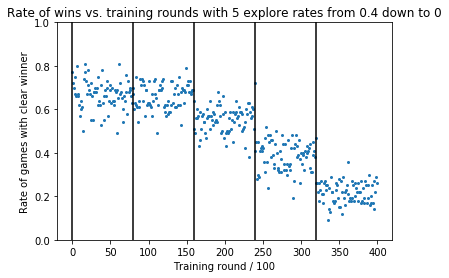

In [17]:
p1grav, p2grav = makedynamic(8000, 5, 0.4, gmove=True)

0.05
training for explore rate 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 378.41it/s]


training for explore rate 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:11<00:00, 341.50it/s]


training for explore rate 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 283.20it/s]


training for explore rate 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 273.49it/s]


training for explore rate 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:15<00:00, 261.92it/s]


training for explore rate 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 248.94it/s]


training for explore rate 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:15<00:00, 251.08it/s]


training for explore rate 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 227.55it/s]


training for explore rate 0.0


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 224.34it/s]


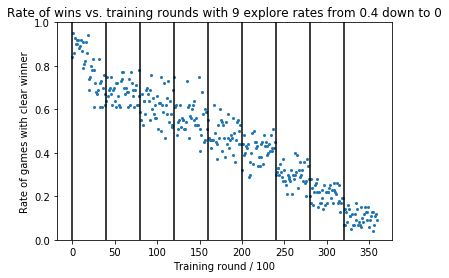

In [39]:
p1grav, p2grav = makedynamic(4000, 9, 0.4, gmove=True)

In [43]:
# p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(p1, human, gravitymove=True)
game.playhuman()

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
Input your action row:2
Input your action col:0
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
| o | x |   | 
-------------
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
| o | x |   | 
-------------
Input your action row:0
Input your action col:1
-------------
|   | o |   | 
-------------
|   | x |   | 
-------------
| o | x |   | 
-------------
-------------
|   | o |   | 
-------------
| x | x |   | 
-------------
| o | x |   | 
-------------
Input your action row:2
Input your action col:2
-------------
|   | o |   | 
-------------
| x | x |   | 
-------------
| o | x | o | 
-------------
-------------
|   | o |   | 
-------------
| x | x | x | 
-------------
| o | x | o | 
-------------
dynamic1 wins!


1

In [44]:
p1grav, p2grav = makedynamic(3000, 9, 0.4, gmove=True)

0.05
training for explore rate 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 385.64it/s]


training for explore rate 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 383.11it/s]


training for explore rate 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 355.02it/s]


training for explore rate 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 329.93it/s]


training for explore rate 0.2


  6%|████▌                                                                         | 177/3000 [00:00<00:10, 279.83it/s]


KeyboardInterrupt: 

In [ ]:
# p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(p1, human, gravitymove=True)
game.playhuman()

0.05
training for explore rate 0.4


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 397.97it/s]


training for explore rate 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 350.46it/s]


training for explore rate 0.3


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 326.10it/s]


training for explore rate 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 335.63it/s]


training for explore rate 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 314.25it/s]


training for explore rate 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.04it/s]


training for explore rate 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.86it/s]


training for explore rate 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 222.81it/s]


training for explore rate 0.0


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.26it/s]


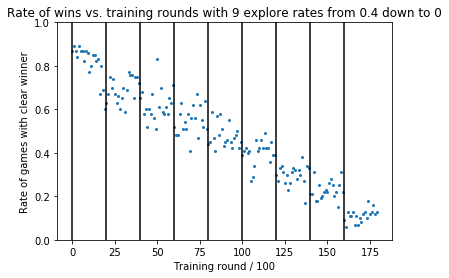

In [36]:
p1grav, p2grav = makedynamic(2000, 9, 0.4, gmove=True)

In [38]:
# p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(human, p2, gravitymove=True)
game.playhuman()

Input your action row:2
Input your action col:2
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
Input your action row:1
Input your action col:2
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
|   | o | x | 
-------------
-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
|   | o | x | 
-------------
Input your action row:0
Input your action col:2
-------------
|   |   | x | 
-------------
|   | o | x | 
-------------
|   | o | x | 
-------------
human wins!


1

0.05
training for explore rate 0.4 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.40it/s]


training for explore rate 0.35 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.35it/s]


training for explore rate 0.3 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.88it/s]


training for explore rate 0.25 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.44it/s]


training for explore rate 0.2 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.07it/s]


training for explore rate 0.15 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.05it/s]


training for explore rate 0.1 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.13it/s]


training for explore rate 0.05 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.95it/s]


training for explore rate 0.0 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.08it/s]


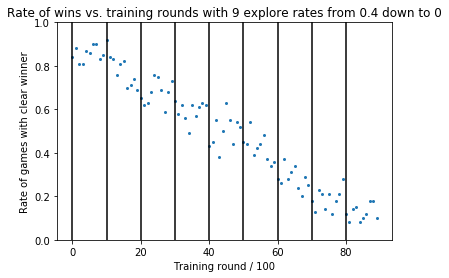

In [25]:
p1grav, p2grav = makedynamic(1000, 9, 0.4, gmove=True, stratnames="grav33")

0.05
training for explore rate 0.4 and alpha 0.4


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.20it/s]


training for explore rate 0.35 and alpha 0.35


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 200.05it/s]


training for explore rate 0.3 and alpha 0.3


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 168.12it/s]


training for explore rate 0.25 and alpha 0.25


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 133.27it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 136.17it/s]


training for explore rate 0.15 and alpha 0.15


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 164.64it/s]


training for explore rate 0.1 and alpha 0.1


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 149.12it/s]


training for explore rate 0.05 and alpha 0.05


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 129.81it/s]


training for explore rate 0.0 and alpha 0.01


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 155.39it/s]


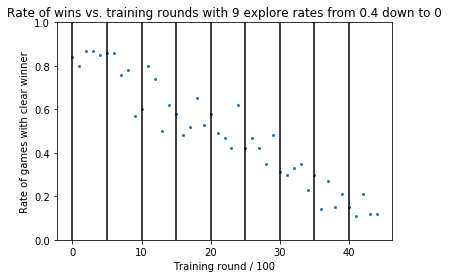

In [29]:
p1grav, p2grav = makedynamic(500, 9, 0.4, gmove=True, movingalpha=True, stratnames="grav33")

In [31]:
# p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(p1grav, p2grav, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | x |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | o |   | 
-----------------
2  |   | x |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | o |   | 
-----------------
2  | x | x |   | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | o |   | 
-----------------
2  | x | x | o | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | o | x | 
-----------------
2  | x | x | o | 
-----------------

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  | o | o | x | 
-----------------
2  | x | x | o | 
-----------

0

# 3x4 first test

Both moving alpha and moving exp rate. For 3x3 needed 500, so for 3x4 try around 27 times more-- 15000.

0.05
training for explore rate 0.4 and alpha 0.4


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:23<00:00, 179.09it/s]


training for explore rate 0.35 and alpha 0.35


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:32<00:00, 161.71it/s]


training for explore rate 0.3 and alpha 0.3


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:38<00:00, 152.96it/s]


training for explore rate 0.25 and alpha 0.25


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:21<00:00, 182.97it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:17<00:00, 193.23it/s]


training for explore rate 0.15 and alpha 0.15


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:02<00:00, 241.65it/s]


training for explore rate 0.1 and alpha 0.1


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:05<00:00, 228.93it/s]


training for explore rate 0.05 and alpha 0.05


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:31<00:00, 163.73it/s]


training for explore rate 0.0 and alpha 0.01


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:27<00:00, 171.31it/s]


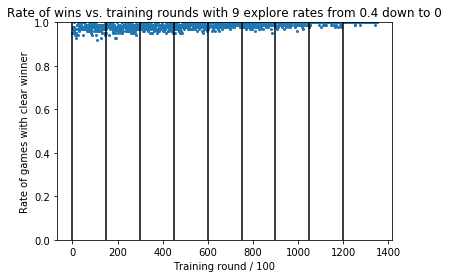

In [30]:
p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               stratnames="grav34")

In [32]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, human, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   | x | 
---------------------

Input your action row:2
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | o | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   | o | x | 
---------------------

Input your action row:1
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   | o |   | 
---------------------
2  | x |   | o | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---

1

In [34]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(human, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

Input your action row:2
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | x |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   | o |   |   | 
---------------------
2  |   | x |   |   | 
---------------------

Input your action row:2
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   | o |   |   | 
---------------------
2  |   | x | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   | o |   |   | 
---------------------
2  | o | x | x |   | 
---------------------

Input your action row:2


1

In [35]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | o |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   | x | 
---------------------
2  |   | o |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   | o |   | x | 
---------------------
2  |   | o |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   | x | 
---------------------
1  |   | o |   | x | 
-----------

1

I don't think we gave it enough training time. What about around 3 times as much? So 50,000 games per learning rate? I'm also concerned that player 2 just isn't learning and is giving up because he's at a severe disadvantage, so let's up his reward for a tie and not penalize him so much for losing.

0.05
training for explore rate 0.4 and alpha 0.4


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:16<00:00, 255.06it/s]


training for explore rate 0.35 and alpha 0.35


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:46<00:00, 221.24it/s]


training for explore rate 0.3 and alpha 0.3


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:01<00:00, 165.78it/s]


training for explore rate 0.25 and alpha 0.25


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:09<00:00, 161.42it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:01<00:00, 165.75it/s]


training for explore rate 0.15 and alpha 0.15


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:04<00:00, 164.24it/s]


training for explore rate 0.1 and alpha 0.1


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:01<00:00, 165.70it/s]


training for explore rate 0.05 and alpha 0.05


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:05<00:00, 163.81it/s]


training for explore rate 0.0 and alpha 0.01


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:56<00:00, 168.58it/s]


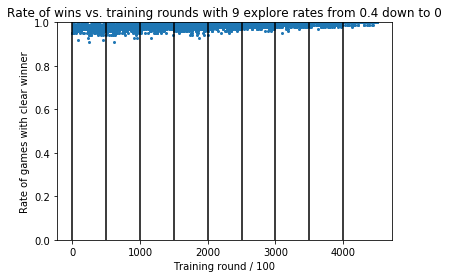

In [39]:
p1grav34, p2grav34 = makedynamic(50000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               stratnames="grav34")

In [45]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   | x | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | o |   |   |   | 
---------------------
2  | o |   | x | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | o |   |   |   | 
-----------

1

Bizarre result from the 3x4 games -- player 1 trains very well 
and achieves human level play, but player 2 still flubs sometimes. I think this is a training fluke.

In [42]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, human, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

Input your action row:2
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | o | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   | x |   | 
---------------------
2  |   | o | x |   | 
---------------------

Input your action row:0
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   | o |   | 
---------------------
1  |   |   | x |   | 
---------------------
2  |   | o | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---

1

In [44]:
# p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(human, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

Input your action row:2
Input your action col:0
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   | o |   | 
---------------------

Input your action row:2
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x | x | o |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   | o |   |   | 
---------------------
2  | x | x | o |   | 
---------------------

Input your action row:1


-1

What if we have each player randomly make a few moves first at high exploration rate? Choose random number of random first moves for each player, more depending on exploration rate. For example, each player first makes a random number of moves equal to a random sample from normal distribution centered around exprate times boardsize over two, with wide standard deviation. Each player makes different number of random moves so players that make fewer random moves can learn how to play against bad players.

Test on tictactoe first. Number of initial random moves for each player is normally distributed around exploration rate squared times board size, with standard deviation equal to half of that. So For exp rate 0.4, we randomly make on average the first 1.44 moves.

0.05
training for explore rate 0.4 and alpha 0.4


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 473.94it/s]


training for explore rate 0.35 and alpha 0.35


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 477.53it/s]


training for explore rate 0.3 and alpha 0.3


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 399.23it/s]


training for explore rate 0.25 and alpha 0.25


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 384.17it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 350.51it/s]


training for explore rate 0.15 and alpha 0.15


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 286.87it/s]


training for explore rate 0.1 and alpha 0.1


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 250.32it/s]


training for explore rate 0.05 and alpha 0.05


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 198.40it/s]


training for explore rate 0.0 and alpha 0.01


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 184.22it/s]


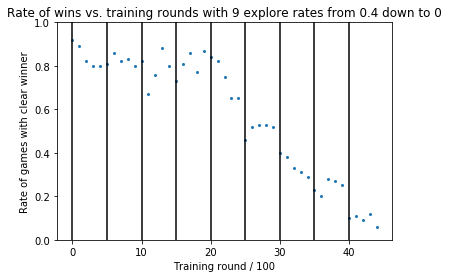

In [58]:
p1grav, p2grav = makedynamic(500, 9, 0.4, gmove=True, movingalpha=True, stratnames="grav33rand", randinit=True)

Actually does better AND ties itself more at the beginning! Let's try with 3x4 now, and with 15000 training rounds (27x what we need for 3x3).

0.05
training for explore rate 0.4 and alpha 0.4


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:48<00:00, 309.13it/s]


training for explore rate 0.35 and alpha 0.35


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:05<00:00, 227.56it/s]


training for explore rate 0.3 and alpha 0.3


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:10<00:00, 212.45it/s]


training for explore rate 0.25 and alpha 0.25


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:14<00:00, 201.63it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:17<00:00, 192.76it/s]


training for explore rate 0.15 and alpha 0.15


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:31<00:00, 163.22it/s]


training for explore rate 0.1 and alpha 0.1


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:30<00:00, 166.48it/s]


training for explore rate 0.05 and alpha 0.05


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:40<00:00, 149.82it/s]


training for explore rate 0.0 and alpha 0.01


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:31<00:00, 164.70it/s]


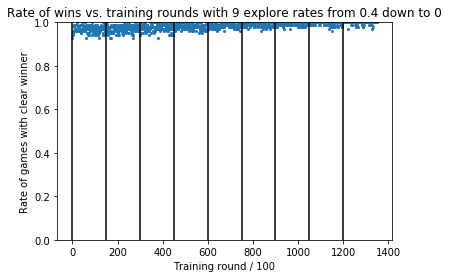

In [65]:
p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               stratnames="grav34rand", randinit=True)

In [66]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   | x |   | 
---------------------
2  | o |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | o |   | x |   | 
---------------------
2  | o |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   | x |   | 
---------------------
1  | o |   | x |   | 
-----------

1

In [67]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, human, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

Input your action row:2
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | o | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   | x |   | 
---------------------
2  |   | o | x |   | 
---------------------

Input your action row:0
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   | o |   | 
---------------------
1  |   |   | x |   | 
---------------------
2  |   | o | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---

1

In [68]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(human, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

Input your action row:2
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   | x |   | 
---------------------

Input your action row:1
Input your action col:0
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | x |   |   |   | 
---------------------
2  | o |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | x |   | o |   | 
---------------------
2  | o |   | x |   | 
---------------------

Input your action row:2


-1

Ok, so it learns, and it can play OK-ish, but it's not great. I think that the amount of randomization is a little too low and player 2 is still punishing itself a bit too much. At lower learning rates after it's converged, player 1 is literally unbeatable, and player 2 just flounders. 

What if we start at an even higher explore rate? And reward p2 even more for ties?

0.05
training for explore rate 0.5 and alpha 0.5


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:40<00:00, 374.52it/s]


training for explore rate 0.45 and alpha 0.45


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:43<00:00, 348.55it/s]


training for explore rate 0.4 and alpha 0.4


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:07<00:00, 220.63it/s]


training for explore rate 0.35 and alpha 0.35


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:50<00:00, 295.07it/s]


training for explore rate 0.3 and alpha 0.3


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:52<00:00, 283.74it/s]


training for explore rate 0.25 and alpha 0.25


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:56<00:00, 267.46it/s]


training for explore rate 0.2 and alpha 0.2


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:55<00:00, 269.47it/s]


training for explore rate 0.15 and alpha 0.15


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:01<00:00, 242.17it/s]


training for explore rate 0.1 and alpha 0.1


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:07<00:00, 223.63it/s]


training for explore rate 0.05 and alpha 0.05


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:07<00:00, 223.07it/s]


training for explore rate 0.0 and alpha 0.01


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:04<00:00, 231.45it/s]


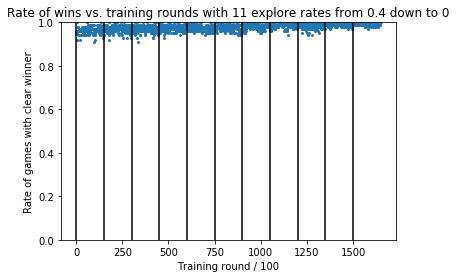

In [12]:
p1grav34, p2grav34 = makedynamic(15000, 11, 0.5, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               stratnames="grav34rand", randinit=True)

In [13]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   | x | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   | o | 
---------------------
2  | o |   | x | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   | o | 
-----------

1

In [14]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1grav34, human, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   | x | 
---------------------

Input your action row:2
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | o |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x | o |   | x | 
---------------------

Input your action row:1
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   | o |   |   | 
---------------------
2  | x | o |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---

1

In [15]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(human, p2grav34, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

Input your action row:2
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   | o |   | 
---------------------
2  |   |   | x |   | 
---------------------

Input your action row:0
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   | x |   | 
---------------------
1  |   |   | o |   | 
---------------------
2  |   |   | x |   | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   | x |   | 
---------------------
1  |   |   | o |   | 
---------------------
2  |   | o | x |   | 
---------------------

Input your action row:1


-1

0.05
training for explore rate 0.5 and alpha 0.5


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [06:45<00:00, 246.63it/s]


training for explore rate 0.45 and alpha 0.45


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [06:56<00:00, 239.91it/s]


training for explore rate 0.4 and alpha 0.4


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [07:08<00:00, 233.43it/s]


training for explore rate 0.35 and alpha 0.35


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [06:33<00:00, 253.89it/s]


training for explore rate 0.3 and alpha 0.3


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [07:39<00:00, 217.63it/s]


training for explore rate 0.25 and alpha 0.25


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:25<00:00, 197.81it/s]


training for explore rate 0.2 and alpha 0.2


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:32<00:00, 195.30it/s]


training for explore rate 0.15 and alpha 0.15


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:33<00:00, 194.81it/s]


training for explore rate 0.1 and alpha 0.1


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [10:05<00:00, 165.02it/s]


training for explore rate 0.05 and alpha 0.05


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [10:07<00:00, 164.70it/s]


training for explore rate 0.0 and alpha 0.01


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:55<00:00, 168.03it/s]


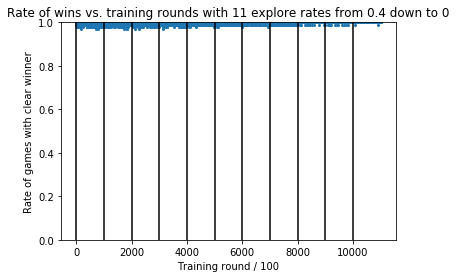

In [19]:
p1grav44, p2grav44 = makedynamic(100000, 11, 0.5, rows=4, cols=4, winc=3, gmove=True, movingalpha=True, 
                               stratnames="grav44rand", randinit=True)

In [22]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(human, p2grav44, numrows=4, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   |   |   | 
---------------------

Input your action row:3
Input your action col:3
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   |   | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   | o | x | 
---------------------

Input your action row:2
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------
3  |   |   | o | x | 
---------------------

   | 0 | 1 | 2 | 3 |
---

-1

Very naive Connect Four. With same amount of training time, but a much larger board, how do our bots do?

In [ ]:
p1grav67, p2grav67 = makedynamic(100000, 11, 0.5, rows=6, cols=7, winc=4, gmove=True, movingalpha=True, 
                               stratnames="grav44rand", randinit=True)

0.05
training for explore rate 0.5 and alpha 0.5


100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [38:49<00:00, 42.92it/s]


training for explore rate 0.45 and alpha 0.45


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:07:47<00:00, 24.59it/s]


training for explore rate 0.4 and alpha 0.4


  9%|██████▋                                                                     | 8796/100000 [02:57<31:10, 48.76it/s]